In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

One_mm_45_df=pd.read_csv("./Downloads/1mm_45 - 1mm_45.csv")
One_mm_90_df=pd.read_csv("./Downloads/1mm_90 - 1mm_90.csv")
Two_mm_45_df=pd.read_csv("./Downloads/2mm_45 - 2mm_45.csv")
Two_mm_90_df=pd.read_csv("./Downloads/2mm_90 - 2mm_90.csv")
Three_mm_45_df=pd.read_csv("./Downloads/3mm_45 - 3mm_45.csv")
Three_mm_90_df=pd.read_csv("./Downloads/3mm_90 - 3mm_90.csv")
Solid_df=pd.read_csv("./Downloads/Solid - Solid.csv")

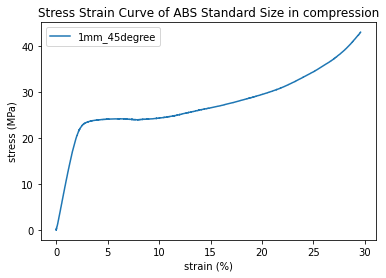

In [2]:
length = 12.7 # test specimen size = 12.7 mm

# Load_One_mm_45_df = One_mm_45_df['Load'].astype(float)
Strain_One_mm_45_df = One_mm_45_df['Strain']
Stress_One_mm_45_df = One_mm_45_df['Load'] / ((length)**2)

plt.plot(Strain_One_mm_45_df, Stress_One_mm_45_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['1mm_45degree'])

plt.show()

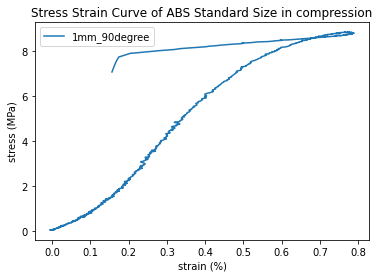

In [3]:
Strain_One_mm_90_df = One_mm_90_df['Strain']
Stress_One_mm_90_df = One_mm_90_df['Load'] / ((length)**2)

plt.plot(Strain_One_mm_90_df, Stress_One_mm_90_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['1mm_90degree'])

plt.show()

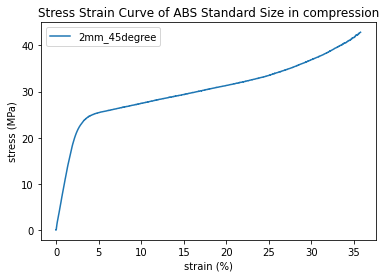

In [4]:
Strain_Two_mm_45_df = Two_mm_45_df['Strain']
Stress_Two_mm_45_df = Two_mm_45_df['Load'] / ((length)**2)

plt.plot(Strain_Two_mm_45_df, Stress_Two_mm_45_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['2mm_45degree'])

plt.show()

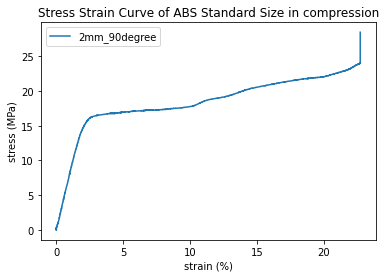

In [5]:
Strain_Two_mm_90_df = Two_mm_90_df['Strain']
Stress_Two_mm_90_df = Two_mm_90_df['Load'] / ((length)**2)

plt.plot(Strain_Two_mm_90_df, Stress_Two_mm_90_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['2mm_90degree'])

plt.show()

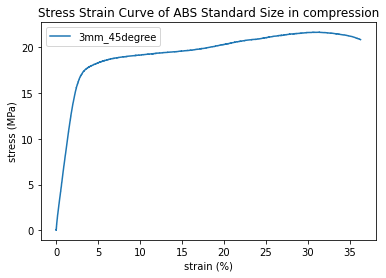

In [6]:
Strain_Three_mm_45_df = Three_mm_45_df['Strain']
Stress_Three_mm_45_df = Three_mm_45_df['Load'] / ((length)**2)

plt.plot(Strain_Three_mm_45_df, Stress_Three_mm_45_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['3mm_45degree'])

plt.show()

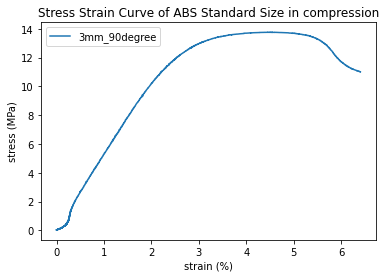

In [7]:
Strain_Three_mm_90_df = Three_mm_90_df['Strain']
Stress_Three_mm_90_df = Three_mm_90_df['Load'] / ((length)**2)

plt.plot(Strain_Three_mm_90_df, Stress_Three_mm_90_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['3mm_90degree'])

plt.show()

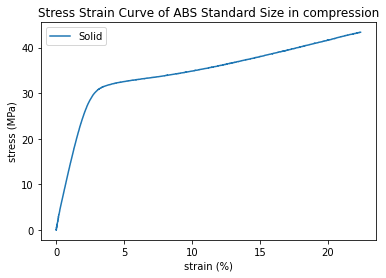

In [8]:
Strain_Solid_df = Solid_df['Strain']
Stress_Solid_df = Solid_df['Load'] / ((length)**2)

plt.plot(Strain_Solid_df, Stress_Solid_df)
plt.xlabel('strain (%)')
plt.ylabel('stress (MPa)')
plt.title('Stress Strain Curve of ABS Standard Size in compression')
plt.legend(['Solid'])

plt.show()

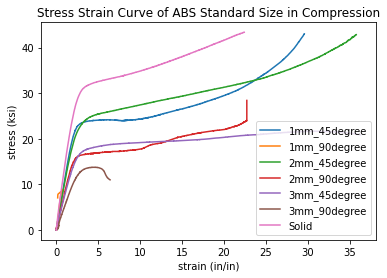

In [9]:
plt.plot(Strain_One_mm_45_df, Stress_One_mm_45_df, Strain_One_mm_90_df, Stress_One_mm_90_df, Strain_Two_mm_45_df, Stress_Two_mm_45_df, Strain_Two_mm_90_df, Stress_Two_mm_90_df, Strain_Three_mm_45_df, Stress_Three_mm_45_df, Strain_Three_mm_90_df, Stress_Three_mm_90_df, Strain_Solid_df, Stress_Solid_df)
plt.xlabel('strain (in/in)')
plt.ylabel('stress (ksi)')
plt.title('Stress Strain Curve of ABS Standard Size in Compression')
plt.legend(['1mm_45degree','1mm_90degree','2mm_45degree','2mm_90degree','3mm_45degree','3mm_90degree','Solid'])

plt.show()

In [15]:
import math
from DataModelDict import DataModelDict as dmd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans as mbkmeans
from sklearn.cluster import KMeans

def young_modulus(data):
    """
    Given a stress-strain dataset, returns Young's Modulus.
    """
    
    yielding = yield_stress(data)[0]

    """Finds the yield index"""
    yield_index = 0
    for index, point in enumerate(data):

        if (point == yielding).all():
            yield_index = index
            break

    """Finds data in elastic region"""
    elastic = data[:yield_index+1]

    """
    Finds the upper yield point (lower yield point is the *yielding* variable). 
    We're taking the first element ([0]) because it returns the 
    first element that meets the criteria in parentheses.
    
    It's a two-dimensional array so we have to do this twice.
    """
    upperyieldpoint_index = np.where(elastic==max(elastic[:,1]))[0][0]
    upperyieldpoint = elastic[upperyieldpoint_index]

    """We estimate the region until the first upper yield point with a linear model"""
    lin_elastic_region = elastic[:upperyieldpoint_index+1]
    
    """The slope of this region is Young's Modulus"""
    return (lin_elastic_region[-1,1]-lin_elastic_region[0,1])/(lin_elastic_region[-1,0]-lin_elastic_region[0,0])

def yield_stress(model, numpoints=1000, cutoff=0.0, startx=None, endx=None, decreasingend=False):
    """
    Finds the yield stress of a dataset **automatically** using kmeans clustering and covariance analysis.
    In order to use this function, you just need to provide it with a stress/strain curve as a numpy array
    where the data is formatted as a two-column array. The first column is all of the stress values,
    and the second column is all of the strain values.
    This works by fitting a logarithmic model as closely as possible to the experimental data (to reduce noise)
    and then to analyze where the slope begins to be decrease relative to the average slope. In other words,
    where :math:`\partial \sigma/ \partial \epsilon < (f(b)-f(a))/(b-a)` where a and b are the beginning and
    end of the interval, respectively. For the purposes of this method, it is important that we have data up
    until the point of failure of a given material.
    """

    """Default interval values"""
    if startx is None:
        startx=min(model[:,0])+0.1
    if endx is None:
        endx=max(model[:,0])

    """We get rid of the noise in the data, and select only positive values (so that logarithms can be taken)"""
    model = log_prep(model,cutoff = cutoff)

    """Fitting a log function to our data, bestfit is that function"""
    bestfit = log_approx(model)

    """
    We look for the place where the slope is average over
    the domain by taking sample points of the logarithmic curve
    """
    gap_len = (endx-startx)/numpoints

    xs = np.linspace(startx,endx,numpoints)
    ys = bestfit(xs)

    """Find the slope of sample points from our log curve"""
    pred_data = combine_data(xs,ys)
    pred_slope = get_slopes(pred_data)

    ave_slope = 0

    """If the slope decreases at the end, we cluster the data to avoid referencing the end of the dataset"""
    if decreasingend is True:
        
        """Defining average slope by observing clusters in data"""
        left, right = kmeanssplit(model)
        leftmid, rightmid = midpoint(left)[None,:], midpoint(right)[None,:]
        ave_slope = (rightmid[0,1]-leftmid[0,1])/(rightmid[0,0]-leftmid[0,0])
            
    else:
        """Otherwise, we get the slope over the whole interval to find where slope begins to decrease overall"""    
        ave_slope = (ys[-1]-ys[0])/(xs[-1]-xs[0])
    
    """As soon as the slope at a point is less than the average slope, we stop"""
    for ind, slope in enumerate(pred_slope):
        if slope<ave_slope:
            break

    """
    We must take into account that we may not have a 
    data point in the experimental set where we have found a result,
    so we find the nearest neighbor in our dataset
    """
    datapointind = ind*gap_len

    """Here we find the nearest neighbor in the dataset"""
    for ind, stra in enumerate(model[:,0]):

        if stra > datapointind:
            return model[ind][None,:]

    raise ValueError("The data does not seem to have a yield")


  
def yield_stress_classic_fitted(data_original, cutoff = 0.0, offset = 0.002):

    """Fit a log curve"""
    data = log_prep(data_original, cutoff = cutoff)
    logapprox = log_approx(data)

    """Take sample data points"""
    data_x = np.linspace(min(data[:,0]),max(data[:,0]),1001)
    data_y = logapprox(data_x)
    data = combine_data(data_x,data_y)

    """Determine average slope"""
    av_slope = (data[-1,1]-data[0,1])/(data[-1,0]-data[0,0]) #rise over run
    closest_index = lambda data, value: (np.abs(data-value)).argmin()
    deriv1st = combine_data(data[:,0], get_slopes(data))

    """Determine where slope is closest to average"""
    bend = closest_index(deriv1st[:,1],av_slope)

    """Fitted this offset line to the left side"""
    young_modulus = (data[bend,1]-data[0,1])/(data[bend,0]-data[0,0])
    def linear_estimation(x):
        return data[0,1] + young_modulus*(x-offset)

    """Sample linear points"""
    linear_y = linear_estimation(data_x)

    """Find closest point in fitted curve"""
    difference_bw_est = np.abs(data_y-linear_y)
    intersection = data[np.where(difference_bw_est==min(difference_bw_est))[0]]

    """Find closest point in original dataset"""
    data = data_original
    intersect_x = intersection[0,0]
    intersect_index = closest_index(data[:,0],intersect_x)

    return data[intersect_index][None,]
    
def yield_stress_classic_unfitted(data, cutoff = 0.0, offset = 0.002):

    """Determine average slope"""
    av_slope = (data[-1,1]-data[0,1])/(data[-1,0]-data[0,0])
    closest_index = lambda data, value: (np.abs(data-value)).argmin()
    deriv1st = combine_data(data[:,0],get_slopes(data))

    """Determine where slope is closest to average"""
    bend = closest_index(deriv1st[:,1],av_slope)

    """Fitted this offset line to the left side"""
    young_modulus = (data[bend,1]-data[0,1])/(data[bend,0]-data[0,0])
    def linear_estimation(x):
        return data[0,1] + young_modulus*(x-offset)

    """Sample linear points"""
    linear_y = linear_estimation(data[:,0])

    """Find closest point in fitted curve"""
    difference_bw_est = np.abs(data[:,1]-linear_y)
    intersection = data[np.where(difference_bw_est==min(difference_bw_est))[0]]

    """Find closest point in original dataset"""
    intersect_x = intersection[0,0]
    intersect_index = closest_index(data[:,0],intersect_x)

    return data[intersect_index][None,]
    
def stress_model(data, yielding = None, strain = None):
    """
    Returns a two-element array with the strain value as the first
    item, and the expected stress as the second if a strain value is provided.
    Otherwise returns a function that will predict stress given a strain value.
    
    Given a dataset and a strain value, predicts what the stress will be at that point.
    As the first parameter, data should be an array with a bunch of entries
    [strain, stress]. 
    The second parameter, strain should be the value for which you wish to estimate 
    stress.
    
    This effectively constructs a physical model for the stress-strain 
    behavior of any material on-the-fly. If no expected strain value is
    provided, this function will simply return the physical model function
    that automatically computes expected stress. This is the preferred use-case 
    for large datasets where the stress-strain curve will need to be predicted repeatedly,
    because otherwise the entire model is recalculated each time, which
    is hugely inefficient.    
    """
    if yielding is None:
        yielding = yield_stress(data)[0]

    """Finds the yield index"""
    yield_index = 0
    for index, point in enumerate(data):

        if (point == yielding).all():
            yield_index = index
            break

    """Separates data into plastic and elastic regions"""
    elastic = data[:yield_index+2]
    plastic = data[yield_index+1:]

    """
    Finds the upper yield point (lower yield point is the *yielding* variable). 
    We're taking the first element ([0]) because it returns the 
    first element that meets the criteria in parentheses.
    
    It's a two-dimensional array so we have to do this twice.
    """
    upperyieldpoint_index = np.where(elastic==max(elastic[:,1]))[0][0]
    upperyieldpoint = elastic[upperyieldpoint_index]

    """We estimate the region until the first upper yield point with a linear model"""
    lin_elastic_region = elastic[:upperyieldpoint_index+1]
    
    """Creating a function that will linearly fit the data"""
    def lin_elastic_model(x):
        m = (lin_elastic_region[-1,1]-lin_elastic_region[0,1])/(lin_elastic_region[-1,0]-lin_elastic_region[0,0])
        return m*x + lin_elastic_region[0,1]
    
    """
    If the upper yield point is the only yield point, 
    then the material doesn't exhibit the yield point phenomenon.
    Otherwise, we establish the domain in which the yield point 
    phenomenon occurs, within which we will be selecting nearest
    neighbors as a method of approximation. The yield point pheno-
    menon occurs when there are two distinct yield points, and 
    that when plastic deformation begins, stress is immediately 
    relieved.
    """
    yieldpointphenom_region = None
    yieldpointphenom = True

    if upperyieldpoint_index==yield_index:
        yieldpointphenom = False        

    if yieldpointphenom:
        yieldpointphenom_region = [upperyieldpoint_index,yield_index]

    """We must determine which domain contains the strain point requested"""
    
    start_yield = upperyieldpoint[0]

    """If we had lists previously, we have an extra dimension we need to get rid of for processing"""
    if yielding.ndim == 2:
        yielding = yielding[0]
    
    def stress_value(strain):
    
        if strain < 0 or strain > max(data[:,0]):
            
            """(Out of range)"""
            return np.nan
        
        elif strain < start_yield:

            """Linear approximation (elastic region)"""
            return [strain, lin_elastic_model(strain)]

        elif yieldpointphenom and strain >= start_yield and strain < yielding[0]:
            
            """Picks the nearest neighbor in this zone"""
            yieldpoints_inregion = elastic[np.where(np.logical_and(elastic[:,0] >= start_yield, elastic[:,0] < yielding[0]) )]

            """As soon as we find a neighbor, we return its value"""
            for val in yieldpoints_inregion:
                if val[0] > strain:
                    return [strain,val [1]]
            
            return yieldpoints_inregion[-1]
            
        elif not yieldpointphenom or strain >= yielding[0]:
               
            """We fit a logarithmic curve to approximate the plastic region"""
            plastic_reg = log_approx(plastic)
            return np.array([strain,plastic_reg(strain)])
            
    """If we should evaluate the function at a point, we'll do so, otherwise we return the function itself"""
    if strain is None:
        return stress_value
        
    else:
        return stress_value(strain)
                 

def log_approx(model):
    """
    Given a dataset with two columns,
    this function returns the logarithmic
    function that best fits that data.
    """
    
    """a and c are parameters"""
    def fit(x, a, c):
        return a*np.log(x)+c

    strain = model[:,0]
    stress = model[:,1]

    """We are fitting a logarithmic curve as closely as possible to the dataset"""
    optimal_params, cov_matrix = curve_fit(fit,strain,stress)
    a, c = optimal_params

    """The fitted version of the fit function"""
    def bestfit(x):
        return a*np.log(x)+c
        
    return bestfit

def log_prep(model, cutoff = 0.025):
    """
    Makes data ready for logarithmic 
    approximation. Deletes data components that
    we know are inaccurate and sets all to be
    positive because logs can only be taken of
    positive values.
    """
    
    model = delete_noise(model,cutoff=cutoff)
    model = adjust(model)
    return model

def delete_noise(model,cutoff = 0.025):
    """
    Takes an array (assuming it's roughly sorted) and returns it after
    a certain value (cutoff), useful for removing early values which may
    contain high levels of noise.
    """

    cur_index = 0

    # deleting noisy values (possible inaccuracies up to .025 in the strain by default)
    for index, num in enumerate(model[:,0]):
        
        if num >= cutoff: 
              
             return model[index:]   
             
def adjust(model):
    """
    Written for convenience because
    it makes all values positive in
    order to be able to take logarithms.
    """
    
    for index, num in enumerate(model[:,1]):
        
        if num<=0:
            model[index,1] = 1
        
    return model

def midpoint(lst):
    """
    Returns the value that is halfway through the
    list (index-wise), left midpoint if
    there are an odd number of points.
    """
    
    length = len(lst)
    return lst[int(length)/2]

def kmeanssplit(data, numclusters=2):
    """Clusters the data into groups (k-means) and returns the split data."""
    
    return splitdata(data,kcluster(data,numclusters=numclusters).predict(data[:,0][:,None]))

def splitdata(data, predictions):
    """Takes predictions from kmeans clustering and split the table into two groups."""
    
    initgroup = predictions[0]
    splitgroup = 0

    for index, val in enumerate(predictions):
        
        # as soon as we reach the new group, we have found our dividing point
        if val != initgroup:
            splitgroup = index
            break
        
    """Instead of creating tuples, we create lists"""
    elastic = combine_data(data[:splitgroup,0],data[:splitgroup,1]) 
    plastic = combine_data(data[splitgroup:,0],data[splitgroup:,1])
    
    return elastic, plastic

def predictlinear(data, step = 0.5):
    """Creates a linear model based on data and predicts its values over the domain, returning the predictions."""
    
    est = linfit(data)
    x_pred = np.arange(min(data[:,0]),max(data[:,0]), step)
    y_pred = est.predict(x_pred[:,None])
    
    return combine_data(x_pred,y_pred)

def samplepoints(function, interval, numpoints):
    """Given a function and an interval (two-element list) and a number of points, applies it to the function and gets sample points at even intervals."""

    x_dom = np.linspace(interval[0],interval[1],numpoints)

    """
    If the function returns lists, then we have to convert them to numpy arrays
    This is necessary for our statistical model prediction method.
    """
    if isinstance(function(0), list):

        nums = np.zeros(2)

        """We convert to numpy arrays"""
        for val in x_dom:
            nextval = np.asarray(function(val))

            """
            If we go out of bounds, the model methods will begin to return nan, so at that point
            we just need to return what we have so far.
            """
            if np.isnan(nextval).any():
                break
            
            nums = np.vstack((nums, nextval[None,:]))

        """Ignoring the first element which is 2 zeros (needed for size consistency when stacking)"""    
        return nums[1:]

    else:
        return combine_data(x_dom,function(x_dom))

def linfit(data, start=None):
    """Fits a linear regression to the data and returns it."""

    return LinearRegression().fit(*format_data(data,start))
    
def kminicluster(data, numclusters, start=None):
    """Clusters the data using mini batch kmeans."""
    
    return mbkmeans(n_clusters=numclusters).fit(*format_data(data,start))
    
def kcluster(data,numclusters,start=None):
    """Clusters the data using regular kmeans clustering."""
    
    return KMeans(n_clusters=numclusters).fit(*format_data(data,start))
    
def format_data(data, start=None):
    """This method will put data in the appropriate format for regression (Scikit-Learn)."""
    
    return (expToTrain(data, start),data[start:,1])
    
def combine_data(data1,data2):
    r"""Given two arrays, returns a combined list where each element is :math:`x_i,y_i`."""

    return np.array([list(a) for a in zip(data1,data2)])

def regularize(data):
    """Converts every non-numerical list value to zero which is useful for analysis later."""
    
    for index, val in enumerate(data):
        if math.isinf(val) or math.isnan(val):
            data[index]=0
        
    return data
    
def get_slopes(model):
    """
    Takes the approximate derivative of a two-column dataset by taking slopes between all of the points.
    The data should be formatted
    [x,y] for each row.
    """
    
    strain = model[:,0]
    stress = model[:,1]

    slopes = []

    """Approximating the partial derivatives of stress/strain"""
    for index in range(len(stress)-1):

        rise = (stress[index+1]-stress[index])
        run = (strain[index+1]-strain[index])

        if run==0:
            slopes.append(0)

        else:
            slopes.append(rise/run)

    return np.array(slopes)

def expToTrain(exp,start=None):
    """Converts a bunch of individual domain values to lists, because each domain value must be iterable for training data."""
    
    x_train = []
    
    for data in exp[start:,0]:
        x_train.append([data, ])
    
    return x_train

In [ ]:
One_mm_45_df.insert(One_mm_45_df.shape[1], 'Stress', Stress_One_mm_45_df)
One_mm_90_df.insert(One_mm_90_df.shape[1], 'Stress', Stress_One_mm_90_df)
Two_mm_45_df.insert(Two_mm_45_df.shape[1], 'Stress', Stress_Two_mm_45_df)
Two_mm_90_df.insert(Two_mm_90_df.shape[1], 'Stress', Stress_Two_mm_90_df)
Three_mm_45_df.insert(Three_mm_45_df.shape[1], 'Stress', Stress_Three_mm_45_df)
Three_mm_90_df.insert(Three_mm_90_df.shape[1], 'Stress', Stress_Three_mm_90_df)
Solid_df.insert(Solid_df.shape[1], 'Stress', Stress_Solid_df)


One_mm_45_df_2 = One_mm_45_df[["Strain", "Stress"]]
One_mm_90_df_2 = One_mm_90_df[["Strain", "Stress"]]
Two_mm_45_df_2 = Two_mm_45_df[["Strain", "Stress"]]
Two_mm_90_df_2 = Two_mm_90_df[["Strain", "Stress"]]
Three_mm_45_df_2 = Three_mm_45_df[["Strain", "Stress"]]
Three_mm_90_df_2 = Three_mm_90_df[["Strain", "Stress"]]
Solid_df_2 = Solid_df[["Strain", "Stress"]]

In [17]:
y1 = young_modulus(One_mm_45_df_2.values)
CS1 = max(One_mm_45_df['Stress'])
y2 = young_modulus(One_mm_90_df_2.values)
CS2 = max(One_mm_90_df['Stress'])
y3 = young_modulus(Two_mm_45_df_2.values)
CS3 = max(Two_mm_45_df['Stress'])
y4 = young_modulus(Two_mm_90_df_2.values)
CS4 = max(Two_mm_90_df['Stress'])
y5 = young_modulus(Three_mm_45_df_2.values)
CS5 = max(Three_mm_45_df['Stress'])
y6 = young_modulus(Three_mm_90_df_2.values)
CS6 = max(Three_mm_90_df['Stress'])
y7 = young_modulus(Solid_df_2.values)
CS7 = max(Solid_df['Stress'])

print('Young modulus for 1mm 45 deg sample: {}'.format(y1))
print(f'The compression strength of the 1mm 45 deg sample is {round(CS1,3)} MPa')
print('\n')
print('Young modulus for 1mm 90 deg sample: {}'.format(y2))
print(f'The compression strength of the 1mm 90 deg sample is {round(CS2,3)} MPa')
print('\n')
print('Young modulus for 2mm 45 deg sample: {}'.format(y3))
print(f'The compression strength of the 2mm 45 deg sample is {round(CS3,3)} MPa')
print('\n')
print('Young modulus for 2mm 90 deg sample: {}'.format(y4))
print(f'The compression strength of the 2mm 90 deg sample is {round(CS4,3)} MPa')
print('\n')
print('Young modulus for 3mm 45 deg sample: {}'.format(y5))
print(f'The compression strength of the 3mm 45 deg sample is {round(CS5,3)} MPa')
print('\n')
print('Young modulus for 3mm 90 deg sample: {}'.format(y6))
print(f'The compression strength of the 4mm 90 deg sample is {round(CS6,3)} MPa')
print('\n')
print('Young modulus for solid sample: {}'.format(y7))
print(f'The compression strength of the solid sample is {round(CS7,3)} MPa')

Young modulus for 1mm 45 deg sample: 4.866714739894649
The compression strength of the 1mm 45 deg sample is 43.008 MPa


Young modulus for 1mm 90 deg sample: 11.641034242136453
The compression strength of the 1mm 90 deg sample is 8.823 MPa


Young modulus for 2mm 45 deg sample: 4.35487235178987
The compression strength of the 2mm 45 deg sample is 42.841 MPa


Young modulus for 2mm 90 deg sample: 4.278672973502492
The compression strength of the 2mm 90 deg sample is 28.421 MPa


Young modulus for 3mm 45 deg sample: 3.1429529624974224
The compression strength of the 3mm 45 deg sample is 21.669 MPa


Young modulus for 3mm 90 deg sample: 5.227809566730245
The compression strength of the 4mm 90 deg sample is 13.763 MPa


Young modulus for solid sample: 8.059448035134912
The compression strength of the solid sample is 43.374 MPa


<ipython-input-15-97f4c1fdd4a9>:309: RuntimeWarning: divide by zero encountered in log
  return a*np.log(x)+c
<ipython-input-15-97f4c1fdd4a9>:309: RuntimeWarning: invalid value encountered in log
  return a*np.log(x)+c
/Users/hsienching/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
